In [69]:
import pandas as pd
import numpy as np
import shap

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Tratamento dos dados

In [2]:
dataset = pd.read_csv('housing_price_dataset.csv')

In [3]:
df = dataset.copy()
df.sample(5)

,area,n_quartos,n_banheiros,vizinhanca,ano_contrucao,preco
16774,2352,2,2,Urban,1956,254190.926443
30034,1803,3,3,Rural,1973,220496.525303
32914,1822,3,2,Suburb,1999,234374.542416
34538,2459,3,1,Urban,2003,242274.395389
47947,2028,2,1,Urban,1981,230505.133375


In [4]:
df.describe()

,area,n_quartos,n_banheiros,ano_contrucao,preco
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2006.374680,3.498700,1.995420,1985.404420,224827.325151
std,575.513241,1.116326,0.815851,20.719377,76141.842966
min,1000.000000,2.000000,1.000000,1950.000000,-36588.165397
25%,1513.000000,3.000000,1.000000,1967.000000,169955.860225
50%,2007.000000,3.000000,2.000000,1985.000000,225052.141166
75%,2506.000000,4.000000,3.000000,2003.000000,279373.630052
max,2999.000000,5.000000,3.000000,2021.000000,492195.259972


In [5]:
df['vizinhanca'].value_counts()

vizinhanca
Suburb    16721
Rural     16676
Urban     16603
Name: count, dtype: int64

In [6]:
dicionario = {
    'Suburb': 'Suburbio',
    'Rural': 'Rural', 
    'Urban': 'Urbano'
}
# trocar os valores da coluna 'vizinhanca' para português
df['vizinhanca'] = df['vizinhanca'].replace(dicionario)

In [7]:
df['area'] = round(df['area']/10.7639, 2)
df['preco'] = round(df['preco'], 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   area           50000 non-null  float64
 1   n_quartos      50000 non-null  int64  
 2   n_banheiros    50000 non-null  int64  
 3   vizinhanca     50000 non-null  object 
 4   ano_contrucao  50000 non-null  int64  
 5   preco          50000 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 2.3+ MB


In [9]:
df.to_csv('housing_price_dataset_2.csv', index=False)

# Análise dos dados

In [45]:
df = pd.read_csv('housing_price_dataset_2.csv')

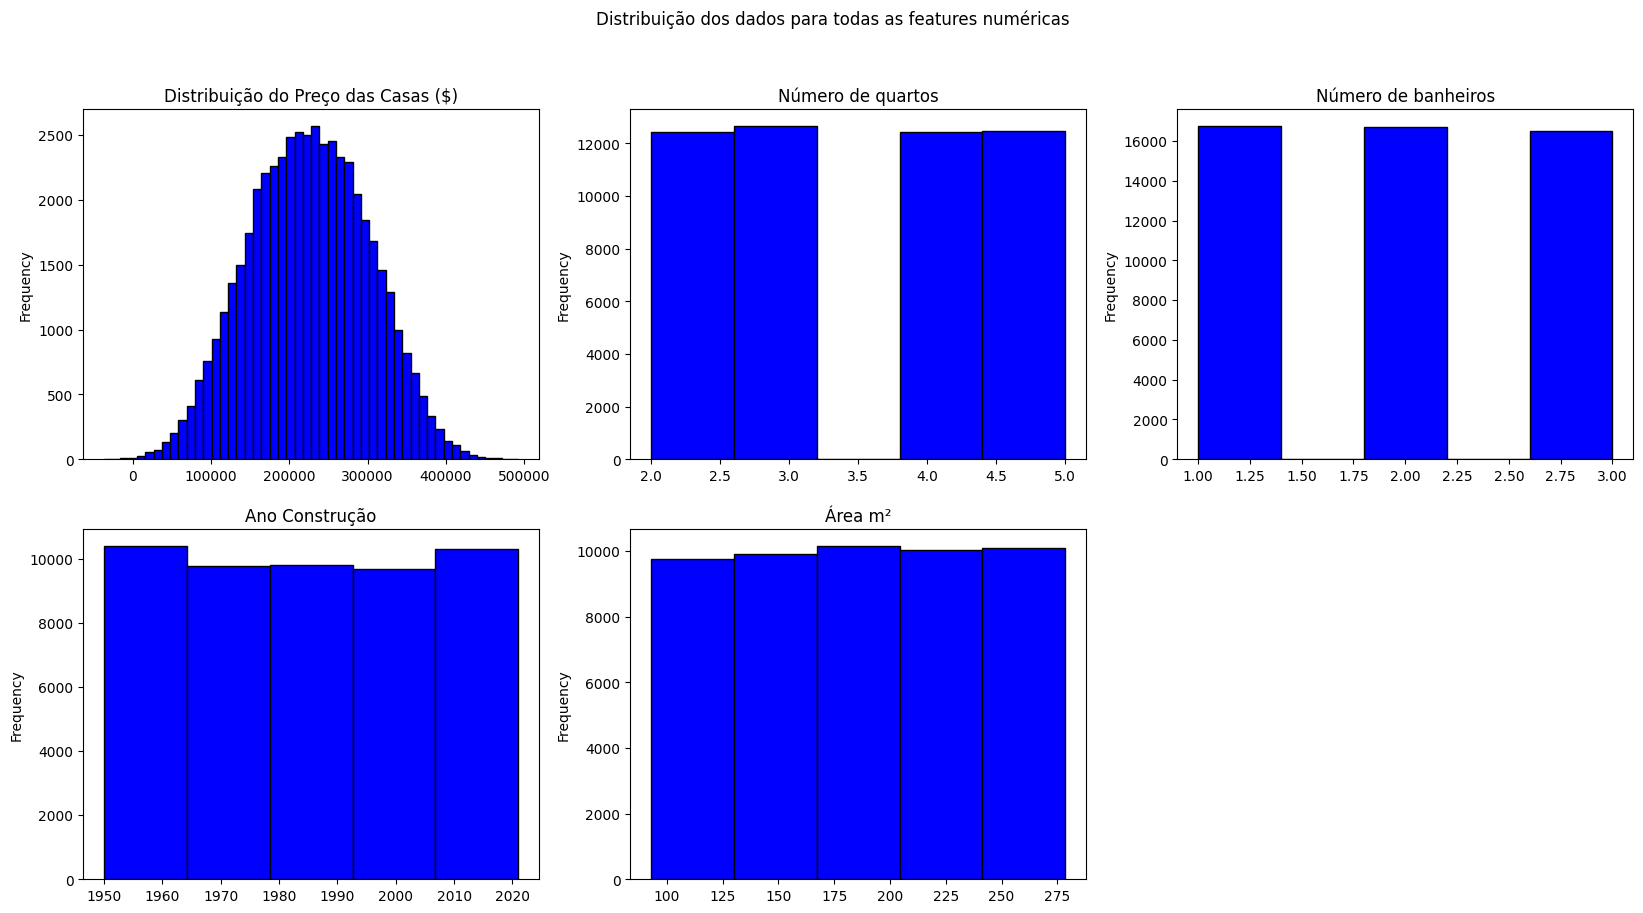

In [55]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
df['preco'].plot(kind='hist', bins=50, color='blue', edgecolor='black')
plt.title('Distribuição do Preço das Casas ($)')

plt.subplot(2, 3, 2)
df['n_quartos'].plot(kind='hist', bins=5, color='blue', edgecolor='black')
plt.title('Número de quartos')

plt.subplot(2, 3, 3)
df['n_banheiros'].plot(kind='hist', bins=5, color='blue', edgecolor='black')
plt.title('Número de banheiros')

plt.subplot(2, 3, 4)
df['ano_contrucao'].plot(kind='hist', bins=5, color='blue', edgecolor='black')
plt.title('Ano Construção')

plt.subplot(2, 3, 5)
df['area'].plot(kind='hist', bins=5, color='blue', edgecolor='black')
plt.title('Área m²')

plt.suptitle('Distribuição dos dados para todas as features numéricas')

plt.show()

- Distribuição normal, típica.
---

# Treinamento

In [67]:
def preparar_dataset(test_size_ = 0.2):

    df = pd.read_csv('housing_price_dataset_2.csv')

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, )
    vetor_codificado = encoder.fit_transform(df[['vizinhanca']])
    nomes_features = list(encoder.get_feature_names_out())
    df_vizinhanca = pd.DataFrame(data=vetor_codificado, columns=nomes_features).astype(np.int0)

    df = pd.concat([df, df_vizinhanca], axis=1)

    df.drop(columns=['vizinhanca'], inplace=True)

    x = df.drop(columns=['preco'])
    y = df['preco']

    scaler = MinMaxScaler(feature_range=(-1, 1))
    yscaler = MinMaxScaler(feature_range=(0, 1))

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size_)

    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    y_train = yscaler.fit_transform(np.array(y_train).reshape(-1, 1))
    y_test = yscaler.transform(np.array(y_test).reshape(-1, 1))

    return x_train, x_test, y_train, y_test, scaler, yscaler

In [76]:
x_train, x_test, y_train, y_test, scaler, yscaler = preparar_dataset()

model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print (f'{mae=}\n{mse=}\n{rmse=}\n{r2=}')


mae=0.07746630255923574
mse=0.009373165222980116
rmse=0.09681510844377605
r2=0.5609027838929317


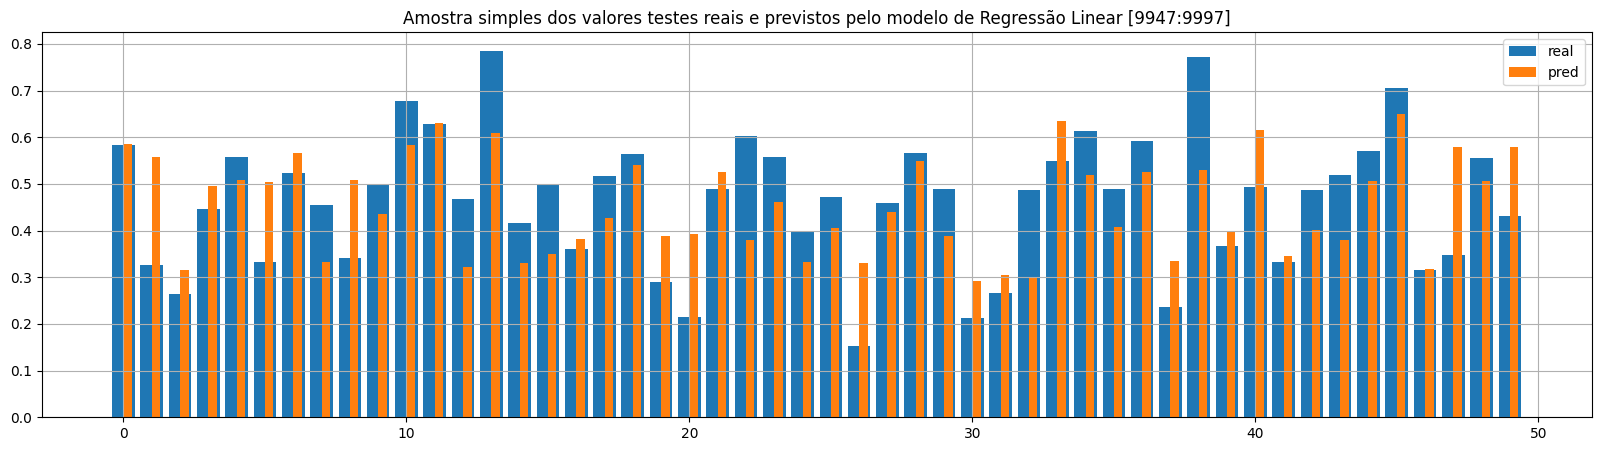

In [121]:
plt.figure(figsize=(20, 5))

n = 50
n1 = np.random.randint(0, len(y_test) - n - 1)
n2 = n1+n

plt.bar(np.arange(n), y_test[n1:n2].reshape(-1), label='real')
plt.bar(np.arange(n), y_pred[n1:n2].reshape(-1), label='pred', width=0.3, align='edge')
plt.grid()

plt.legend()
plt.title(f'Amostra simples dos valores testes reais e previstos pelo modelo de Regressão Linear [{n1}:{n2}]')

plt.show()

- 
---

# Shap Values